In [43]:
from utils.cli_utils import main_opt_get, main_read_config
from utils.config_utils import instantiate_from_config
opt = main_opt_get(['-c', 'configs/base_config/Lung/ResNet_Total.yaml'])
base_config = main_read_config(opt)
base_config['model']['params']['pretrained'] = False

pl_dataset = instantiate_from_config(base_config['data'])
model = instantiate_from_config(base_config['model'])

In [44]:
import torch

model_dir = '/data1/wengtaohan/Code/quick_train/logs/ResNet_Total/D2024-12-06T03-09-50_ResNet_Total/checkpoints/epoch=68-val_loss=0.06.ckpt'

model_dict = torch.load(model_dir, weights_only=True)["state_dict"]
missing_key, unexpect_key = model.load_state_dict(model_dict, strict=False)

In [45]:
import os
from torchvision import transforms
from PIL import Image
import json

dir_path = '/data1/wengtaohan/Dataset/Lung/process_data/total_data/test/'
image_name = '00002.jpg'
img_path = os.path.join(dir_path, image_name)

json_path = '/data1/wengtaohan/Dataset/Lung/process_data/total_data/data_config.json' # 保存图像的label信息

label_map = {'normal': 0, 'lesion': 1}

# 获取图像文件名

image_id = image_name.split('.')[0]  # 获取图像的 ID（去掉 .jpg 后缀）

with open(json_path, 'r') as f:
    labels = json.load(f)

# 获取对应的标签
image_label = labels['test'].get(image_id, 'unknown')
image_label = label_map[image_label]
image_label = torch.tensor(image_label, dtype=torch.long)

# 打开图像
image = Image.open(img_path).convert('RGB')

img_transform = transforms.Compose([
                transforms.Resize(256),  # 调整图像大小
                transforms.CenterCrop(256),  # 中心裁剪
                transforms.ToTensor(),  # 转为Tensor
            ])
image = img_transform(image)
print(image.shape)
print(image_label)

torch.Size([3, 256, 256])
tensor(0)


label: normal predict:normal


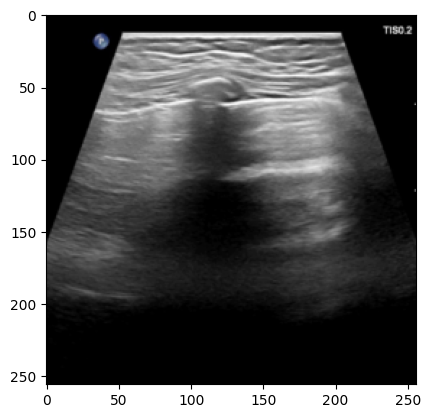

In [55]:
from matplotlib import pyplot as plt
img = torch.unsqueeze(image, 0)

model.eval()

predict = model(img)
predict = torch.max(predict, 1)[1][0].detach().cpu().numpy()
label = image_label.detach().cpu().numpy()

label_list = ['normal', 'lesion']
print('label: %s predict:%s'%(label_list[label],label_list[predict]))
np_image = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(np_image, cmap='gray',vmin=0, vmax=1)
# plt.show()
plt.savefig('test2.jpg')